In [1]:
%%capture
!pip install rasterio

In [2]:
import numpy as np
from itertools import product
import os
import zipfile
import shutil
import cv2
import csv
import pandas as pd
import pdb
import glob
import random
import tensorflow as tf
import multiprocessing
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from skimage.io import imread, imshow
from skimage.transform import resize
import rasterio as rs
import matplotlib.pyplot as plt
from pathlib import Path
from rasterio.windows import Window
from rasterio.plot import show

2023-07-10 22:04:18.682392: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-10 22:04:18.687608: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-10 22:04:18.817527: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-10 22:04:18.819384: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 22:04:20.550933: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
num_cores = multiprocessing.cpu_count()
config = tf.compat.v1.ConfigProto(inter_op_parallelism_threads=num_cores,
                                  intra_op_parallelism_threads=num_cores)
tf.compat.v1.Session(config=config)


In [ ]:
# def split_cells(x):
#     # split on the _
#     a = x.split('_')
#     b = '_'.join(a[1:])
#     return b


# def verificar_proporcao_segmentacao(imagem, channel=0):
#     """Verifica a proporção da imagem que possui segmentação
#     imagem: array or image
#     """
#     if not isinstance(imagem, np.ndarray):
#         imagem = np.asarray(imagem).astype('uint8')
#     if len(imagem.shape) == 2:
#         proporcao_pixel = np.count_nonzero(imagem[:, :] == 1) / (
#                 np.count_nonzero(imagem[:, :] == 0) + np.count_nonzero(imagem[:, :] == 1))
#     else:
#         proporcao_pixel = np.count_nonzero(imagem[:, :, channel] == 1) / (
#                 np.count_nonzero(imagem[:, :, channel] == 0) + np.count_nonzero(imagem[:, :, channel] == 1))
#     return proporcao_pixel


# def plot_acc_epochs(history, plot_type, epoch_start=0):
#     """Plotar grafico de acurácia ou loss pela época
#     history.history: saida do metodo gerado pelo model.fit
#     plot_type: str, 'accuracy' ou 'loss'
#     """
#     ctype = history[plot_type]
#     val_ctype = history['val_' + plot_type]
#     # epochs=range(len(ctype)) + epoch_start
#     epochs = np.add(list(range(len(ctype))), [epoch_start])

#     plt.plot(epochs, ctype, label='Trainin_' + plot_type, color='blue')
#     plt.plot(epochs, val_ctype, label='Validation_' + plot_type, color='red')
#     plt.legend()
#     plt.title("Training and Validation " + plot_type)


# def show_map(path,pic1, pic2, pic3):
#     img1 = rs.open(path + pic1)
#     img2 = rs.open(path + pic2)
#     seg = rs.open(path + pic3)

#     print(img1.count, img1.height, img1.width, img1.crs)

#     band1 = img1.read(1)
#     band2 = img2.read(1)
#     saida = seg.read(1)

#     lista = [band1, band2, saida]
#     title = ['Banda 1', 'Banda 2', 'Segmentação']
#     plt.figure(figsize=(25, 45))

#     for i, name in enumerate(lista):
#         shape = lista[i].shape
#         plt.subplot(131 + i)
#         plt.imshow(lista[i])
#         plt.title(str(title[i]) + ' - Formato: ' + str(shape))
#     plt.show()

In [4]:
original_teste = "/home/cristiano/Downloads/Imagens_Landsat-8"
imagens_teste_descompactadas = "/home/cristiano/Downloads/Imagens_Landsat-8/TESTE_DESCOMPACTADO"

In [28]:
#Definir os caminhos das pastas notebook
composta = "/home/cristiano/Downloads/Imagens_Landsat-8/TESTE_DESCOMPACTADO/COMPOSTA"
composta_recorte = "/home/cristiano/Downloads/Imagens_Landsat-8/TESTE_DESCOMPACTADO/COMPOSTA_RECORT"
banda06 = "/home/cristiano/Downloads/Imagens_Landsat-8/TESTE_DESCOMPACTADO/BANDA06"
banda06_recorte = "/home/cristiano/Downloads/Imagens_Landsat-8/TESTE_DESCOMPACTADO/BANDA06_RECORT"
banda07 = "/home/cristiano/Downloads/Imagens_Landsat-8/TESTE_DESCOMPACTADO/BANDA07"
banda07_recorte = "/home/cristiano/Downloads/Imagens_Landsat-8/TESTE_DESCOMPACTADO/BANDA07_RECORT"
segmentada = "/home/cristiano/Downloads/Imagens_Landsat-8/TESTE_DESCOMPACTADO/SEGMENTADA"
segmentada_recorte = "/home/cristiano/Downloads/Imagens_Landsat-8/TESTE_DESCOMPACTADO/SEGMENTADA_RECORT"
segmentada_recorte_lat_long = '/home/cristiano/Downloads/Imagens_Landsat-8/TESTE_DESCOMPACTADO/SEGMENTADA_RECORT_LAT-LONG/'
preds = '/home/cristiano/Downloads/Imagens_Landsat-8/TESTE_DESCOMPACTADO/PREDS/INDICES-60-40'
saida_rede= '/home/cristiano/Downloads/Imagens_Landsat-8/TESTE_DESCOMPACTADO/SAIDA_REDE'
img_saida_rede = '/home/cristiano/Downloads/Imagens_Landsat-8/TESTE_DESCOMPACTADO/IMAGENS_UNET'

# Criar as pastas se não existirem
for pasta in [composta, composta_recorte, banda06, banda06_recorte, banda07, banda07_recorte, 
              segmentada, segmentada_recorte, segmentada_recorte_lat_long, preds, saida_rede, img_saida_rede]:
    if not os.path.exists(pasta):
        os.makedirs(pasta)

width = 64  # Largura do recorte em pixels
height = 64  # Altura do recorte em pixels

In [ ]:
# # Definir os caminhos das pastas trabalho
# composta = "/home/emanoelcepr/Downloads/TESTE_DESCOMPACTADO/COMPOSTA"
# composta_recorte = "/home/emanoelcepr/Downloads/TESTE_DESCOMPACTADO/COMPOSTA_RECORT"
# banda06 = "/home/emanoelcepr/Downloads/TESTE_DESCOMPACTADO/BANDA06"
# banda06_recorte = "/home/emanoelcepr/Downloads/TESTE_DESCOMPACTADO/BANDA06_RECORT"
# banda07 = "/home/emanoelcepr/Downloads/TESTE_DESCOMPACTADO/BANDA07"
# banda07_recorte = "/home/emanoelcepr/Downloads/TESTE_DESCOMPACTADO/BANDA07_RECORT"
# segmentada = "/home/emanoelcepr/Downloads/TESTE_DESCOMPACTADO/SEGMENTADA"
# segmentada_recorte = "/home/emanoelcepr/Downloads/TESTE_DESCOMPACTADO/SEGMENTADA_RECORT"
# saida_rede= "/home/emanoelcepr/Downloads/TESTE_DESCOMPACTADO/SAIDA_REDE"
# segmentada_recorte_lat_long = '/home/emanoelcepr/Downloads/Imagens_Landsat-8/TESTE_DESCOMPACTADO/SEGMENTADA_RECORT_LAT-LONG/'
# preds = '/home/emanoelcepr/Downloads/Imagens_Landsat-8/TESTE_DESCOMPACTADO/PREDS/INDICES-60-40'

# # Criar as pastas se não existirem
# for pasta in [composta, composta_recorte, banda06, banda06_recorte, banda07, banda07_recorte, segmentada, segmentada_recorte, saida_rede, segmentada_recorte_lat_long, preds]:
#     if not os.path.exists(pasta):
#         os.makedirs(pasta)


# width = 64  # Largura do recorte em pixels
# height = 64  # Altura do recorte em pixels

In [6]:
# # Verifica se o diretório "imagens_teste_descompactadas" existe
# if not os.path.exists(imagens_teste_descompactadas):
#     os.makedirs(imagens_teste_descompactadas)
# else:
#     # Remove todos os arquivos e subdiretórios dentro de "imagens_teste_descompactadas"
#     for arquivo in os.listdir(imagens_teste_descompactadas):
#         caminho_arquivo = os.path.join(imagens_teste_descompactadas, arquivo)
#         if os.path.isfile(caminho_arquivo):
#             os.remove(caminho_arquivo)
#         elif os.path.isdir(caminho_arquivo):
#             shutil.rmtree(caminho_arquivo)

# Percorre os arquivos na pasta "original_teste"
for arquivo in os.listdir(original_teste):
    path = os.path.join(original_teste, arquivo)
    if arquivo.endswith('.zip'):
        # Extrai o arquivo .zip para a pasta "imagens_teste_descompactadas"
        with zipfile.ZipFile(path, 'r') as zip_ref:
            zip_ref.extractall(imagens_teste_descompactadas)

# Exibe os arquivos extraídos na pasta "imagens_teste_descompactadas"
arquivos_extraidos = os.listdir(imagens_teste_descompactadas)
print("Arquivos extraídos:")
for arquivo in arquivos_extraidos:
    print(arquivo)


Arquivos extraídos:
BANDA07
2023-05-15-00:00_2023-05-15-23:59_Landsat_8-9_L2_B07_(Raw).tiff
SEGMENTADA_RECORT
SEGMENTADA_RECORT_LAT-LONG
2023-05-15-00:00_2023-05-15-23:59_Landsat_8-9_L2_B05_(Raw).tiff
2023-05-15-00:00_2023-05-15-23:59_Landsat_8-9_L2_B04_(Raw).tiff
SEGMENTADA
IMAGENS_UNET
2023-06-16-00:00_2023-06-16-23:59_Landsat_8-9_L2_B01_(Raw).tiff
SAIDA_REDE
BANDA06_RECORT
PREDS
2023-06-16-00:00_2023-06-16-23:59_Landsat_8-9_L2_B02_(Raw).tiff
BANDA07_RECORT
2023-05-15-00:00_2023-05-15-23:59_Landsat_8-9_L2_Custom_script.tiff
2023-05-15-00:00_2023-05-15-23:59_Landsat_8-9_L2_B06_(Raw).tiff
2023-06-16-00:00_2023-06-16-23:59_Landsat_8-9_L2_B06_(Raw).tiff
2023-05-15-00:00_2023-05-15-23:59_Landsat_8-9_L2_B10_(Raw).tiff
2023-05-15-00:00_2023-05-15-23:59_Landsat_8-9_L2_B01_(Raw).tiff
2023-06-16-00:00_2023-06-16-23:59_Landsat_8-9_L2_B07_(Raw).tiff
2023-06-16-00:00_2023-06-16-23:59_Landsat_8-9_L2_B04_(Raw).tiff
COMPOSTA
BANDA06
2023-06-16-00:00_2023-06-16-23:59_Landsat_8-9_L2_B03_(Raw).tiff
COM

In [7]:
# Mover arquivos para as pastas correspondentes
for arquivo in np.sort(os.listdir(imagens_teste_descompactadas)):
    path = os.path.join(imagens_teste_descompactadas, arquivo)

    if arquivo.endswith("B06_(Raw).tiff"):
        # Mover o arquivo para a pasta "banda06"
        caminho_destino = os.path.join(banda06, arquivo)
        shutil.move(path, caminho_destino)
    elif arquivo.endswith("B07_(Raw).tiff"):
        # Mover o arquivo para a pasta "banda07"
        caminho_destino_banda07 = os.path.join(banda07, arquivo)
        shutil.move(path, caminho_destino_banda07)
    elif arquivo.endswith("Custom_script.tiff"):
        # Mover o arquivo para a pasta "composta"
        caminho_destino_composta = os.path.join(composta, arquivo)
        shutil.move(path, caminho_destino_composta)

# Copiar arquivos da pasta "banda07" para a pasta "segmentada"
for nome_arquivo in np.sort(os.listdir(banda07)):
    # Construir o caminho completo do arquivo de origem
    caminho_origem = os.path.join(banda07, nome_arquivo)

    # Construir o caminho completo do arquivo de destino
    caminho_destino = os.path.join(segmentada, nome_arquivo)

    # Copiar o arquivo
    shutil.copy2(caminho_origem, caminho_destino)

# Listar os arquivos nas pastas
print("Arquivos na pasta 'banda06':")
arquivos_banda11 = np.sort(os.listdir(banda06))
for arquivo in arquivos_banda11:
    print(arquivo)

print("Arquivos na pasta 'banda07':")
arquivos_banda07 = np.sort(os.listdir(banda07))
for arquivo in arquivos_banda07:
    print(arquivo)

print("Arquivos na pasta 'segmentadas':")
arquivos_segmentados = np.sort(os.listdir(segmentada))
for arquivo in arquivos_segmentados:
    print(arquivo)

print("Arquivos na pasta 'composta':")
arquivos_composta = np.sort(os.listdir(composta))
for arquivo in arquivos_composta:
    print(arquivo)


Arquivos na pasta 'banda06':
2023-05-15-00:00_2023-05-15-23:59_Landsat_8-9_L2_B06_(Raw).tiff
2023-06-16-00:00_2023-06-16-23:59_Landsat_8-9_L2_B06_(Raw).tiff
Arquivos na pasta 'banda07':
2023-05-15-00:00_2023-05-15-23:59_Landsat_8-9_L2_B07_(Raw).tiff
2023-06-16-00:00_2023-06-16-23:59_Landsat_8-9_L2_B07_(Raw).tiff
Arquivos na pasta 'segmentadas':
2023-05-15-00:00_2023-05-15-23:59_Landsat_8-9_L2_B07_(Raw).tiff
2023-06-16-00:00_2023-06-16-23:59_Landsat_8-9_L2_B07_(Raw).tiff
Arquivos na pasta 'composta':
2023-05-15-00:00_2023-05-15-23:59_Landsat_8-9_L2_Custom_script.tiff
2023-06-16-00:00_2023-06-16-23:59_Landsat_8-9_L2_Custom_script.tiff


In [8]:
# Encontre todos os arquivos .tiff no diretório
arquivos_tiff = glob.glob(os.path.join(imagens_teste_descompactadas, '*.tiff'))

# Exclua os arquivos encontrados
for arquivo in arquivos_tiff:
    os.remove(arquivo)

print("Arquivos .tiff excluídos com sucesso!")


Arquivos .tiff excluídos com sucesso!


In [9]:
def binarizar_imagens(diretorio_entrada, diretorio_saida):
    # Listar os arquivos no diretório de entrada
    arquivos = os.listdir(diretorio_entrada)

    for arquivo in arquivos:
        # Obter o caminho completo do arquivo de entrada
        caminho_entrada = os.path.join(diretorio_entrada, arquivo)

        # Verificar se o arquivo é uma imagem
        if arquivo.endswith('.tiff') or arquivo.endswith('.tif'):
            # Carregar a imagem em escala de cinza
            imagem = cv2.imread(caminho_entrada, cv2.IMREAD_GRAYSCALE)

            # Normalizar a imagem entre 0 e 1
            imagem_normalizada = imagem / 255.0

            # Aplicar a binarização
            _, imagem_binarizada = cv2.threshold(imagem_normalizada, 0.5, 1, cv2.THRESH_BINARY)

            # Obter o nome do arquivo de saída
            nome_arquivo_saida = os.path.splitext(arquivo)[0] + '_binarizada.tif'

            # Definir o caminho completo do arquivo de saída
            caminho_saida = os.path.join(diretorio_saida, nome_arquivo_saida)

            # Salvar a imagem binarizada entre 0 e 1
            cv2.imwrite(caminho_saida, imagem_binarizada.astype(np.float32))

# Diretório de entrada das imagens em escala de cinza
diretorio_entrada = segmentada

# Diretório de saída para as imagens binarizadas
diretorio_saida = segmentada

# Binarizar as imagens no diretório de entrada e salvar as imagens binarizadas no diretório de saída
binarizar_imagens(diretorio_entrada, diretorio_saida)


In [10]:
# Percorrer os arquivos no diretório
for arquivo in os.listdir(segmentada):
    if arquivo.endswith("B07_(Raw).tiff"):
        path = os.path.join(segmentada, arquivo)
        os.remove(path)
    elif "B07_(Raw)_binarizada" in arquivo:
        novo_nome = arquivo.replace("B07_(Raw)_binarizada", "segmentada")
        caminho_origem = os.path.join(segmentada, arquivo)
        caminho_destino = os.path.join(segmentada, novo_nome)
        os.rename(caminho_origem, caminho_destino)

In [11]:
#RECORTE AS IMAGENS DA BANDA06

def recortar_imagens(banda06, banda06_recorte, width, height):
    count = 0
    for filename in os.listdir(banda06):
        input_path = os.path.join(banda06, filename)
        with rs.open(input_path) as src:
            transform = src.transform
            for x in range(0, src.width, width):
                for y in range(0, src.height, height):
                    # Calcula as coordenadas da janela de recorte
                    window = Window(x, y, width, height)

                    # Lê os dados da imagem dentro da janela de recorte
                    data = src.read(window=window)

                    # Atualiza o transform para a nova janela de recorte
                    new_transform = rs.windows.transform(window, transform)

                    # Atualiza o perfil da imagem com as novas dimensões e transform
                    profile = src.profile
                    profile.update(width=width, height=height, transform=new_transform)

                    # Salva a imagem recortada preservando o georreferenciamento
                    output_path = os.path.join(banda06_recorte, f"{os.path.basename(input_path[:-10])}{x}_{y}.tiff")
                    with rs.open(output_path, 'w', **profile) as dst:
                        dst.write(data)
                        count += 1
                        
    print(f"Total de imagens recortadas: {count}")

recortar_imagens(banda06, banda06_recorte, width, height)


Total de imagens recortadas: 12


In [12]:
def recortar_imagens(banda07, banda07_recorte, width, height):
    count = 0
    for filename in os.listdir(banda07):
        input_path = os.path.join(banda07, filename)
        with rs.open(input_path) as src:
            transform = src.transform
            for x in range(0, src.width, width):
                for y in range(0, src.height, height):
                    # Calcula as coordenadas da janela de recorte
                    window = Window(x, y, width, height)

                    # Lê os dados da imagem dentro da janela de recorte
                    data = src.read(window=window)

                    # Atualiza o transform para a nova janela de recorte
                    new_transform = rs.windows.transform(window, transform)

                    # Atualiza o perfil da imagem com as novas dimensões e transform
                    profile = src.profile
                    profile.update(width=width, height=height, transform=new_transform)

                    # Salva a imagem recortada preservando o georreferenciamento
                    output_path = os.path.join(banda07_recorte, f"{os.path.basename(input_path[:-10])}{x}_{y}.tiff")
                    with rs.open(output_path, 'w', **profile) as dst:
                        dst.write(data)
                        count += 1
    print(f"Total de imagens recortadas: {count}")

recortar_imagens(banda07, banda07_recorte, width, height)


Total de imagens recortadas: 12


In [13]:
def recortar_imagens(segmentada, segmentada_recorte, width, height):
    count = 0
    for filename in np.sort(os.listdir(segmentada)):
        input_path = os.path.join(segmentada, filename)
        with rs.open(input_path) as src:
            transform = src.transform
            for x in range(0, src.width, width):
                for y in range(0, src.height, height):
                    # Calcula as coordenadas da janela de recorte
                    window = Window(x, y, width, height)

                    # Lê os dados da imagem dentro da janela de recorte
                    data = src.read(window=window)

                    # Atualiza o transform para a nova janela de recorte
                    new_transform = rs.windows.transform(window, transform)

                    # Atualiza o perfil da imagem com as novas dimensões e transform
                    profile = src.profile
                    profile.update(width=width, height=height, transform=new_transform)

                    # Salva a imagem recortada preservando o georreferenciamento
                    output_path = os.path.join(segmentada_recorte, f"{os.path.basename(input_path[:-4])}_{x}_{y}.tiff")
                    with rs.open(output_path, 'w', **profile) as dst:
                        dst.write(data)
                        count += 1
    print(f"Total de imagens recortadas: {count}")

recortar_imagens(segmentada, segmentada_recorte, width, height)


Total de imagens recortadas: 12


/home/cristiano/.local/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/cristiano/.local/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


In [ ]:
# def recortar_imagens(segmentada, segmentada_recorte, width, height):
#     count = 0
#     for filename in os.listdir(segmentada):
#         input_path = os.path.join(segmentada, filename)
#         with rs.open(input_path) as src:
#             transform = src.transform
#             for x in range(0, src.width, width):
#                 for y in range(0, src.height, height):
#                     # Calcula as coordenadas da janela de recorte
#                     window = Window(x, y, width, height)

#                     # Lê os dados da imagem dentro da janela de recorte
#                     data = src.read(window=window)

#                     # Atualiza o transform para a nova janela de recorte
#                     new_transform = rs.windows.transform(window, transform)

#                     # Atualiza o perfil da imagem com as novas dimensões e transform
#                     profile = src.profile
#                     profile.update(width=width, height=height, transform=new_transform)

#                     # Salva a imagem recortada preservando o georreferenciamento
#                     output_path = os.path.join(segmentada_recorte, f"{os.path.basename(input_path[:-4])}_{x}_{y}.tiff")
#                     with rs.open(output_path, 'w', **profile) as dst:
#                         dst.write(data)
#                         count += 1
#     print(f"Total de imagens recortadas: {count}")

# recortar_imagens(segmentada, saida_rede, width, height)

In [14]:
def recortar_imagens(composta, composta_recorte, width, height):
    count = 0
    for filename in os.listdir(composta):
        input_path = os.path.join(composta, filename)
        with rs.open(input_path) as src:
            transform = src.transform
            for x in range(0, src.width, width):
                for y in range(0, src.height, height):
                    # Calcula as coordenadas da janela de recorte
                    window = Window(x, y, width, height)

                    # Lê os dados da imagem dentro da janela de recorte
                    data = src.read(window=window)

                    # Atualiza o transform para a nova janela de recorte
                    new_transform = rs.windows.transform(window, transform)

                    # Atualiza o perfil da imagem com as novas dimensões e transform
                    profile = src.profile
                    profile.update(width=width, height=height, transform=new_transform)

                    # Salva a imagem recortada preservando o georreferenciamento
                    output_path = os.path.join(composta_recorte, f"{os.path.basename(input_path[:-11])}{x}_{y}.tiff")
                    with rs.open(output_path, 'w', **profile) as dst:
                        dst.write(data)
                        count += 1
    print(f"Total de imagens recortadas: {count}")

recortar_imagens(composta, composta_recorte, width, height)


Total de imagens recortadas: 12


In [ ]:
# import os
# import rasterio

# # Valor do pixel que desejamos verificar
# valor_pixel = 1

# # Listar os arquivos no diretório de entrada
# arquivos = os.listdir(segmentada_recorte)

# # Caminho completo para o arquivo de saída
# caminho_arquivo_saida = os.path.join(segmentada_recorte_lat_long, 'informacoes.csv')

# # Abrir o arquivo de saída para escrever as informações de índice, latitude e longitude
# with open(caminho_arquivo_saida, 'w') as arquivo_saida:
#     # Escrever o cabeçalho do arquivo de saída
#     arquivo_saida.write("Índice; Pixel; Latitude; Longitude\n")
    
#     # Iterar sobre cada arquivo no diretório de entrada
#     for indice, arquivo in enumerate(arquivos):
#         if arquivo.endswith('.tiff') or arquivo.endswith('.tif'):
#             # Caminho completo para o arquivo de entrada
#             caminho_arquivo = os.path.join(segmentada_recorte, arquivo)

#             # Abrir o arquivo TIFF
#             with rasterio.open(caminho_arquivo) as src:
#                 # Obter a transformação que mapeia as coordenadas dos pixels para coordenadas geográficas
#                 transform = src.transform

#                 # Ler a imagem como uma matriz numpy
#                 imagem = src.read()

#                 # Verificar se a imagem possui apenas uma banda (assumindo que estamos interessados em uma única banda)
#                 if len(imagem.shape) == 3 and imagem.shape[0] == 1:
#                     dados_banda = imagem[0]  # Selecionar a primeira banda
#                 else:
#                     dados_banda = imagem  # Utilizar a imagem completa

#                 # Variável para controlar se o primeiro pixel foi encontrado
#                 primeiro_pixel_encontrado = False

#                 # Iterar sobre cada pixel
#                 for y in range(dados_banda.shape[0]):
#                     for x in range(dados_banda.shape[1]):
#                         # Verificar se o pixel possui o valor desejado e ainda não foi encontrado
#                         if dados_banda[y, x] == valor_pixel and not primeiro_pixel_encontrado:
#                             # Calcular a latitude e longitude do pixel
#                             lon, lat = transform * (x, y)
                            
#                             # Escrever as informações de índice, latitude e longitude no arquivo de saída
#                             arquivo_saida.write(f"{indice}; ({x}, {y}); {lat}; {lon}\n")
                            
#                             # Atualizar a variável para indicar que o primeiro pixel foi encontrado
#                             primeiro_pixel_encontrado = True
#                             break  # Interromper o loop para a imagem atual se um pixel for encontrado

#                 # Se nenhum pixel com valor 1 foi encontrado, não salvar informações no arquivo de saída
#                 # if not primeiro_pixel_encontrado:
#                 #     arquivo_saida.write(f"{indice}; N/A; N/A; N/A\n")


In [46]:
# Valor do pixel que desejamos verificar
valor_pixel = 1

# Listar os arquivos no diretório de entrada
img_segmentada = os.listdir(segmentada_recorte)

# Caminho completo para o arquivo de saída
caminho_arquivo_saida = os.path.join(saida_rede, 'informacoes_img_segmentada.csv')

# Abrir o arquivo de saída para escrever as informações de índice, latitude e longitude
with open(caminho_arquivo_saida, 'w') as arquivo_saida:
    # Escrever o cabeçalho do arquivo de saída
    arquivo_saida.write("Indice;Pixel;Latitude;Longitude\n")

    # Iterar sobre cada arquivo no diretório de entrada
    for indice, arquivo in enumerate(img_segmentada):
        if arquivo.endswith('.tiff') or arquivo.endswith('.tif'):
            # Caminho completo para o arquivo de entrada
            path = os.path.join(segmentada_recorte, arquivo)

            # Abrir o arquivo TIFF
            with rs.open(path) as src:
                # Obter a transformação que mapeia as coordenadas dos pixels para coordenadas geográficas
                transform = src.transform

                # Ler a imagem como uma matriz numpy
                imagem = src.read()

                # Verificar se a imagem possui apenas uma banda (assumindo que estamos interessados em uma única banda)
                if len(imagem.shape) == 3 and imagem.shape[0] == 1:
                    dados_banda = imagem[0]  # Selecionar a primeira banda
                else:
                    dados_banda = imagem  # Utilizar a imagem completa

                # Iterar sobre cada pixel
                for y in range(dados_banda.shape[0]):
                    for x in range(dados_banda.shape[1]):
                        # Verificar se o pixel possui o valor desejado
                        if dados_banda[y, x] == valor_pixel:
                            # Calcular a latitude e longitude do pixel
                            lon, lat = transform * (x, y)
                            
                            # Escrever as informações de latitude e longitude no arquivo de saída
                            arquivo_saida.write(f"{indice}; ({x}, {y}); {lat}; {lon}\n")



In [ ]:
# # Valor do pixel que desejamos verificar
# valor_pixel = 1

# # Listar os arquivos no diretório de entrada
# arquivos = os.listdir(segmentada_recorte)

# # Caminho completo para o arquivo de saída
# caminho_arquivo_saida = os.path.join(segmentada_recorte_lat_long, 'informacoes.csv')

# # Abrir o arquivo de saída para escrever as informações de índice, latitude e longitude
# with open(caminho_arquivo_saida, 'w') as arquivo_saida:
#     # Escrever o cabeçalho do arquivo de saída
#     arquivo_saida.write("Indice;Pixel;Latitude;Longitude\n")
    
#     # Iterar sobre cada arquivo no diretório de entrada
#     for indice, arquivo in enumerate(arquivos):
#         if arquivo.endswith('.tiff') or arquivo.endswith('.tif'):
#             # Caminho completo para o arquivo de entrada
#             caminho_arquivo = os.path.join(segmentada_recorte, arquivo)

#             # Abrir o arquivo TIFF
#             with rs.open(caminho_arquivo) as src:
#                 # Obter a transformação que mapeia as coordenadas dos pixels para coordenadas geográficas
#                 transform = src.transform

#                 # Ler a imagem como uma matriz numpy
#                 imagem = src.read()

#                 # Verificar se a imagem possui apenas uma banda (assumindo que estamos interessados em uma única banda)
#                 if len(imagem.shape) == 3 and imagem.shape[0] == 1:
#                     dados_banda = imagem[0]  # Selecionar a primeira banda
#                 else:
#                     dados_banda = imagem  # Utilizar a imagem completa

#                 # Variável para controlar se o primeiro pixel foi encontrado
#                 primeiro_pixel_encontrado = False

#                 # Iterar sobre cada pixel
#                 for y in range(dados_banda.shape[0]):
#                     for x in range(dados_banda.shape[1]):
#                         # Verificar se o pixel possui o valor desejado e ainda não foi encontrado
#                         if dados_banda[y, x] == valor_pixel and not primeiro_pixel_encontrado:
#                             # Calcular a latitude e longitude do pixel
#                             lon, lat = transform * (x, y)
                            
#                             # Escrever as informações de índice, latitude e longitude no arquivo de saída
#                             arquivo_saida.write(f"{indice}; ({x}, {y}); {lat}; {lon}\n")
                            
#                             # Atualizar a variável para indicar que o primeiro pixel foi encontrado
#                             primeiro_pixel_encontrado = True
#                             break  # Interromper o loop para a imagem atual se um pixel for encontrado


In [21]:
def buscar_imagem_por_indice(segmentada_recorte, posicao):
    # Obter a lista de arquivos no diretório com extensão .tiff
    img_segmentada = np.sort(glob.glob(f"{segmentada_recorte}/*.tiff"))

    # Verificar se o índice fornecido está dentro do intervalo válido
    if posicao < 0 or posicao >= len(img_segmentada):
        print(f"O índice {posicao} está fora do intervalo válido.")
        return

    # Caminho completo para o arquivo de imagem com base no índice fornecido
    path = img_segmentada[posicao]

    # Abrir o arquivo .tiff
    with rs.open(path) as src:
        # Ler a imagem
        imagem = src.read(1)  # Lê a primeira banda da imagem

    # Plotar a imagem
    show(imagem)

# Posição da imagem a ser buscada
posicao = 53

# Chamar a função para buscar e exibir a imagem com base na posição
buscar_imagem_por_indice(saida_rede, posicao)


O índice 53 está fora do intervalo válido.


In [ ]:
# import glob
# import rasterio
# from rasterio.plot import show

# def buscar_imagem_por_indice(diretorio, indice):
#     # Obter a lista de arquivos no diretório com extensão .tiff
#     arquivos = glob.glob(f"{diretorio}/*.tiff")

#     # Verificar se o índice fornecido está dentro do intervalo válido
#     if indice < 0 or indice >= len(arquivos):
#         print(f"O índice {indice} está fora do intervalo válido.")
#         return

#     # Caminho completo para o arquivo de imagem com base no índice fornecido
#     caminho_arquivo = arquivos[indice]

#     # Abrir o arquivo .tiff
#     with rasterio.open(caminho_arquivo) as src:
#         # Ler a imagem
#         imagem = src.read(1)  # Lê a primeira banda da imagem

#     # Plotar a imagem
#     show(imagem)

# # Diretório onde as imagens estão armazenadas
# diretorio = '/home/cristiano/Downloads/Imagens_Landsat-8/TESTE_DESCOMPACTADO/SEGMENTADA_RECORT/'

# # Índice da imagem a ser buscada
# indice = 58

# # Chamar a função para buscar e exibir a imagem com base no índice
# buscar_imagem_por_indice(diretorio, indice)

FIT DO TESTE

In [22]:
# Obter número de imagens de teste
NUM_TEST_IMAGES = len(os.listdir(segmentada_recorte))

# Obter listas de nomes de arquivo
composta_list = np.sort(os.listdir(composta_recorte))
banda06_list = np.sort(os.listdir(banda06_recorte))
banda07_list = np.sort(os.listdir(banda07_recorte))
seg_list = np.sort(os.listdir(segmentada_recorte))

# Criar DataFrame usando contexto do Pandas
with pd.option_context("display.max_columns", None):
    df_test = pd.DataFrame({'composta': composta_list,'banda06': banda06_list, 'banda07': banda07_list, 'seg': seg_list})

# Obter listas de IDs
test_composta_id_list = df_test['composta'].tolist()
test_banda06_id_list = df_test['banda06'].tolist()
test_banda07_id_list = df_test['banda07'].tolist()
test_mask_id_list = df_test['seg'].tolist()

# Definir shapes dos arrays
IMG_HEIGHT = 64
IMG_WIDTH = 64
IMG_CHANNELS = 2

X_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
Z_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, 1), dtype=float)


# Iterar sobre as listas usando enumerate
for i, (composta_id, banda06_id, banda07_id, mask_id) in enumerate(zip(test_composta_id_list, test_banda06_id_list, test_banda07_id_list, test_mask_id_list)):
    # Construir caminhos completos
    path_composta = os.path.join(composta_recorte, composta_id)
    path_banda06 = os.path.join(banda06_recorte, banda06_id)
    path_banda07 = os.path.join(banda07_recorte, banda07_id)
    path_seg = os.path.join(segmentada_recorte, mask_id)

    try:
        # Ler as imagens
        with rs.open(path_composta) as img_composta, rs.open(path_banda06) as img06, rs.open(path_banda07) as img07, rs.open(path_seg) as img3:
            band06 = img06.read(1)
            band07 = img07.read(1)
            seg = img3.read(1)
            composta = img_composta.read(1)
        
        # Juntar as bandas
        bandas = np.dstack((band06, band07))
        
        # Transformar bandas em valores entre 0 e 255
        bandas = (bandas / 255) * 255
        
        # Inserir a imagem em X_test
        X_test[i] = bandas
        
        # Redimensionar a máscara para a forma (64, 64, 1)
        mask = resize(seg, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
        
        # Normalizar valores da máscara para True/False (ou 0/1)
        mask = mask.astype(bool)
        
        # Inserir a máscara em Y_test
        Y_test[i] = mask

        # Redimensionar a máscara para a forma (64, 64, 1)
        img_composta = resize(composta, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
               
        # Inserir a composta em Z_test
        Z_test[i] = img_composta
    
    except (rs.RasterioIOError, FileNotFoundError) as e:
        print(f"Erro ao abrir a imagem {banda06_id}: {e}")

print('Shape do Y_test:', Y_test.shape)
print('Shape do X_test:', X_test.shape)
print('Shape do Z_test:', Z_test.shape)

Shape do Y_test: (12, 64, 64, 1)
Shape do X_test: (12, 64, 64, 2)
Shape do Z_test: (12, 64, 64, 1)


In [23]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, \
    Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate, RandomContrast
from keras.callbacks import EarlyStopping, ModelCheckpoint


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  

    model = Model(inputs, outputs, name="U-Net")
    return model

my_unet = build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), n_classes=1)
my_unet.compile(optimizer='adam', loss='binary_crossentropy')
print(my_unet.summary())

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1216        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 64, 64, 64)   0           ['batch_normalization[0][0]']

In [24]:
# use the best epoch
my_unet.load_weights('/home/cristiano/projetos/unet/model-60-40.h5')
test_preds = my_unet.predict(X_test)

# Threshold the predictions

preds_test_thresh = (test_preds >= 0.5).astype(np.uint8)
preds_test_thresh = preds_test_thresh.reshape((len(X_test), IMG_WIDTH, IMG_HEIGHT, 1))

print("Evaluate on test data")
results = my_unet.evaluate(X_test, Y_test)
print("test loss: ", results)

"""IOU"""

mean_iou1 = tf.keras.metrics.MeanIoU(num_classes=2)
mean_iou1.update_state(Y_test, preds_test_thresh, sample_weight=None)
iou = mean_iou1.result().numpy()
print("IOU: ", iou)

"""Accuracy"""

acc1 = tf.keras.metrics.Accuracy()
acc1.update_state(Y_test, preds_test_thresh)
acc = acc1.result().numpy()
print("acurácia: ", acc)

1/1 [==============================] - 2s 2s/step
Evaluate on test data
1/1 [==============================] - 2s 2s/step - loss: 0.0081
test loss:  0.008107983507215977
IOU:  0.73178357
acurácia:  0.9989217


In [25]:
# # Salvar imagens de saída 
# Diretório onde deseja salvar as imagens de saída
diretorio_saida = "/home/cristiano/Downloads/Imagens_Landsat-8/TESTE_DESCOMPACTADO/IMAGENS_UNET/"

# Certificar-se de que o diretório de saída existe
os.makedirs(diretorio_saida, exist_ok=True)

# Iterar sobre as imagens de saída geradas pela rede
for i, img_saida_rede in enumerate(preds_test_thresh):
    # Converter a matriz de saída para o tipo uint8
    img_saida_rede = (img_saida_rede.astype(np.uint8) * 255).squeeze()

    # Converter a matriz em uma imagem PIL
    imagem_pil = Image.fromarray(img_saida_rede, mode='L')

    # Caminho completo para salvar a imagem de saída
    caminho_imagem_saida = os.path.join(diretorio_saida, f'unet_{i}.tiff')

    # Salvar a imagem de saída
    imagem_pil.save(caminho_imagem_saida)


In [29]:
# Valor mínimo do pixel que desejamos verificar
valor_minimo = 1

# Caminho completo para o arquivo de saída
caminho_arquivo_saida = os.path.join(saida_rede, 'informacoes_saida_unet.csv')

# Abrir o arquivo de saída para escrever as informações de índice, posição do pixel e caminho da imagem
with open(caminho_arquivo_saida, 'w') as arquivo_saida:
    # Escrever o cabeçalho do arquivo de saída
    arquivo_saida.write("Posicao;Pixel;Caminho\n")

    # Listar os arquivos no diretório de saída da rede
    img_unet = os.listdir(img_saida_rede)

    # Iterar sobre cada arquivo no diretório de saída
    for posicao, arquivo in enumerate(img_unet):
        if arquivo.endswith('.tiff') or arquivo.endswith('.tif'):
            # Caminho completo para o arquivo de saída da rede
            path = os.path.join(img_saida_rede, arquivo)

            # Abrir o arquivo TIFF
            with rs.open(path) as src:
                # Ler a imagem como uma matriz numpy
                imagem = src.read(1)  # Lê apenas a primeira banda da imagem

                # Encontrar os pixels com valor maior que zero
                pixels_maiores_que_zero = np.where(imagem >= valor_minimo)

                # Verificar se foram encontrados pixels maiores que zero
                if pixels_maiores_que_zero[0].size > 0:
                    for i in range(len(pixels_maiores_que_zero[0])):
                        # Obter as coordenadas (x, y) do pixel
                        x = pixels_maiores_que_zero[1][i]
                        y = pixels_maiores_que_zero[0][i]
                        
                        # Escrever as informações de índice, posição do pixel e caminho da imagem no arquivo de saída
                        arquivo_saida.write(f"{posicao}; ({x}, {y}); {path}\n")


In [30]:
def encontrar_indices_com_valor(matrizes):
    return [indice for indice, matriz in enumerate(matrizes) if np.any(matriz == 1)]


In [31]:
def salvar_indices_em_arquivo(indices, saida_rede):
    arquivo_indices = Path(saida_rede) / 'indices_unet.csv'
    with arquivo_indices.open('w') as arquivo:
        arquivo.writelines(f'{indice}\n' for indice in indices)

In [32]:
def salvar_quantidade_pixels_em_csv(indices, quantidades, saida_rede):
    arquivo_csv = Path(saida_rede) / 'qtd_pixel.csv'
    resolucao_espacial = 30
    with arquivo_csv.open('w', newline='') as arquivo:
        escritor_csv = csv.writer(arquivo)
        escritor_csv.writerow(['Índice', 'Quantidade de Pixels', 'Resolução Espacial', 'Área'])
        for indice, quantidade in zip(indices, quantidades):
            area = quantidade * resolucao_espacial 
            escritor_csv.writerow([indice, quantidade, resolucao_espacial, area])

In [33]:
def quantidade_de_pixels_com_valor(matrizes):
    quantidades = []
    for matriz in matrizes:
        if np.any(matriz == 1):
            quantidades.append(np.count_nonzero(matriz == 1))
    return quantidades


In [34]:
def salvar_resultados(preds_test_thresh, saida_rede):
    """
    Salva os resultados da segmentação em arquivos.
    """
    # Cria o diretório de destino, se necessário
    Path(saida_rede).mkdir(parents=True, exist_ok=True)

    # Encontra os índices das matrizes com valor 1
    indices_matrizes_com_valor = encontrar_indices_com_valor(preds_test_thresh)

    # Salva os índices em um arquivo
    salvar_indices_em_arquivo(indices_matrizes_com_valor, saida_rede)

    # Calcula a quantidade de pixels por imagem
    quantidade_de_pixel_por_imagem = quantidade_de_pixels_com_valor(preds_test_thresh)

    # Salva a quantidade de pixels em um arquivo CSV
    salvar_quantidade_pixels_em_csv(indices_matrizes_com_valor, quantidade_de_pixel_por_imagem, saida_rede)

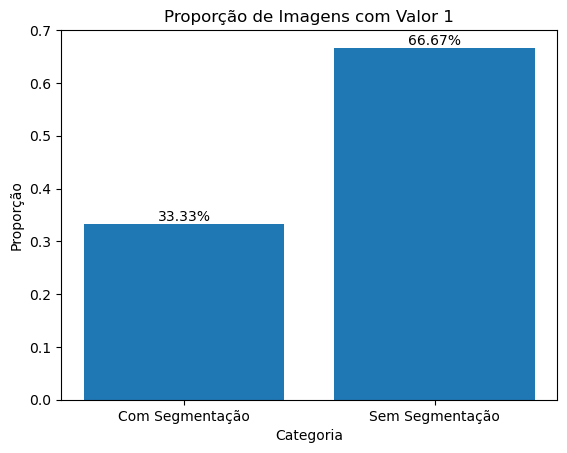

In [35]:
def gerar_grafico_proporcao(preds_test_thresh):
    """
    Gera um gráfico de barras mostrando a proporção de imagens com e sem segmentação.
    """
    total_matrizes = len(preds_test_thresh)
    total_matrizes_com_valor = len(encontrar_indices_com_valor(preds_test_thresh))
    total_matrizes_sem_valor = total_matrizes - total_matrizes_com_valor

    proporcao_com_valor = total_matrizes_com_valor / total_matrizes
    proporcao_sem_valor = total_matrizes_sem_valor / total_matrizes

    categorias = ['Com Segmentação', 'Sem Segmentação']
    proporcoes = [proporcao_com_valor, proporcao_sem_valor]

    plt.bar(categorias, proporcoes)
    plt.title('Proporção de Imagens com Valor 1')
    plt.xlabel('Categoria')
    plt.ylabel('Proporção')

    for categoria, proporcao in zip(categorias, proporcoes):
        plt.text(categoria, proporcao, f'{proporcao:.2%}', ha='center', va='bottom')

# Exemplo de uso das funções
salvar_resultados(preds_test_thresh, saida_rede)
gerar_grafico_proporcao(preds_test_thresh)
plt.show()


In [36]:
#     Lê o arquivo de índices e retorna os índices, latitudes e longitudes.
def ler_arquivo_indices(saida_rede, nome_arquivo_indices):
    caminho_arquivo_indices = os.path.join(saida_rede, nome_arquivo_indices)
    with open(caminho_arquivo_indices, 'r') as arquivo_indices:
        linhas = arquivo_indices.readlines()
        linhas_dados = linhas[1:]  # Pular a primeira linha dos rótulos de coluna
        indices = [int(indice.strip().split(';')[0]) for indice in linhas_dados]
        latitudes = [float(indice.strip().split(';')[4]) for indice in linhas_dados]
        longitudes = [float(indice.strip().split(';')[5]) for indice in linhas_dados]

    return indices, latitudes, longitudes

In [37]:
def ler_arquivo_qtd_pixel(saida_rede, nome_arquivo_qtd_pixel):
    """
    Lê o arquivo de quantidade de pixels e retorna um dicionário com a quantidade de pixels e área por índice.
    """
    caminho_arquivo_qtd_pixel = os.path.join(saida_rede, nome_arquivo_qtd_pixel)
    with open(caminho_arquivo_qtd_pixel, 'r') as arquivo_qtd_pixel:
        leitor_csv = csv.reader(arquivo_qtd_pixel)
        cabecalho = next(leitor_csv)
        dados_qtd_pixel = list(leitor_csv)

    mapa_qtd_pixel_area = {int(dado[0]): (int(dado[1]), int(dado[3])) for dado in dados_qtd_pixel}

    return mapa_qtd_pixel_area

In [47]:
# # Caminho para o arquivo informacoes_saida.csv

# Caminho para o arquivo informacoes_saida.csv
caminho_informacoes = '/home/cristiano/Downloads/Imagens_Landsat-8/TESTE_DESCOMPACTADO/informacoes_saida_unet.csv'

# Caminho para o outro arquivo com as informações de caminho
caminho_outro_arquivo = '/home/cristiano/Downloads/Imagens_Landsat-8/TESTE_DESCOMPACTADO/informacoes_img_segmentada.csv'

# Carregar os dados do arquivo informacoes_saida.csv em um DataFrame do pandas
informacoes_df = pd.read_csv(os.path.join(saida_rede, 'informacoes_saida_unet.csv'), delimiter=';')

# Carregar os dados do outro arquivo em outro DataFrame
outro_df = pd.read_csv(os.path.join(saida_rede, 'informacoes_img_segmentada.csv'), delimiter=';')

# Mesclar os DataFrames com base no valor da coluna "Pixel"
merged_df = informacoes_df.merge(outro_df, on='Pixel')

# Salvar o resultado da mesclagem em um novo arquivo CSV
merged_df.to_csv(os.path.join(saida_rede, 'informacoes_merged.csv'), sep=';', index=False)

[3, 9, 6, 5]


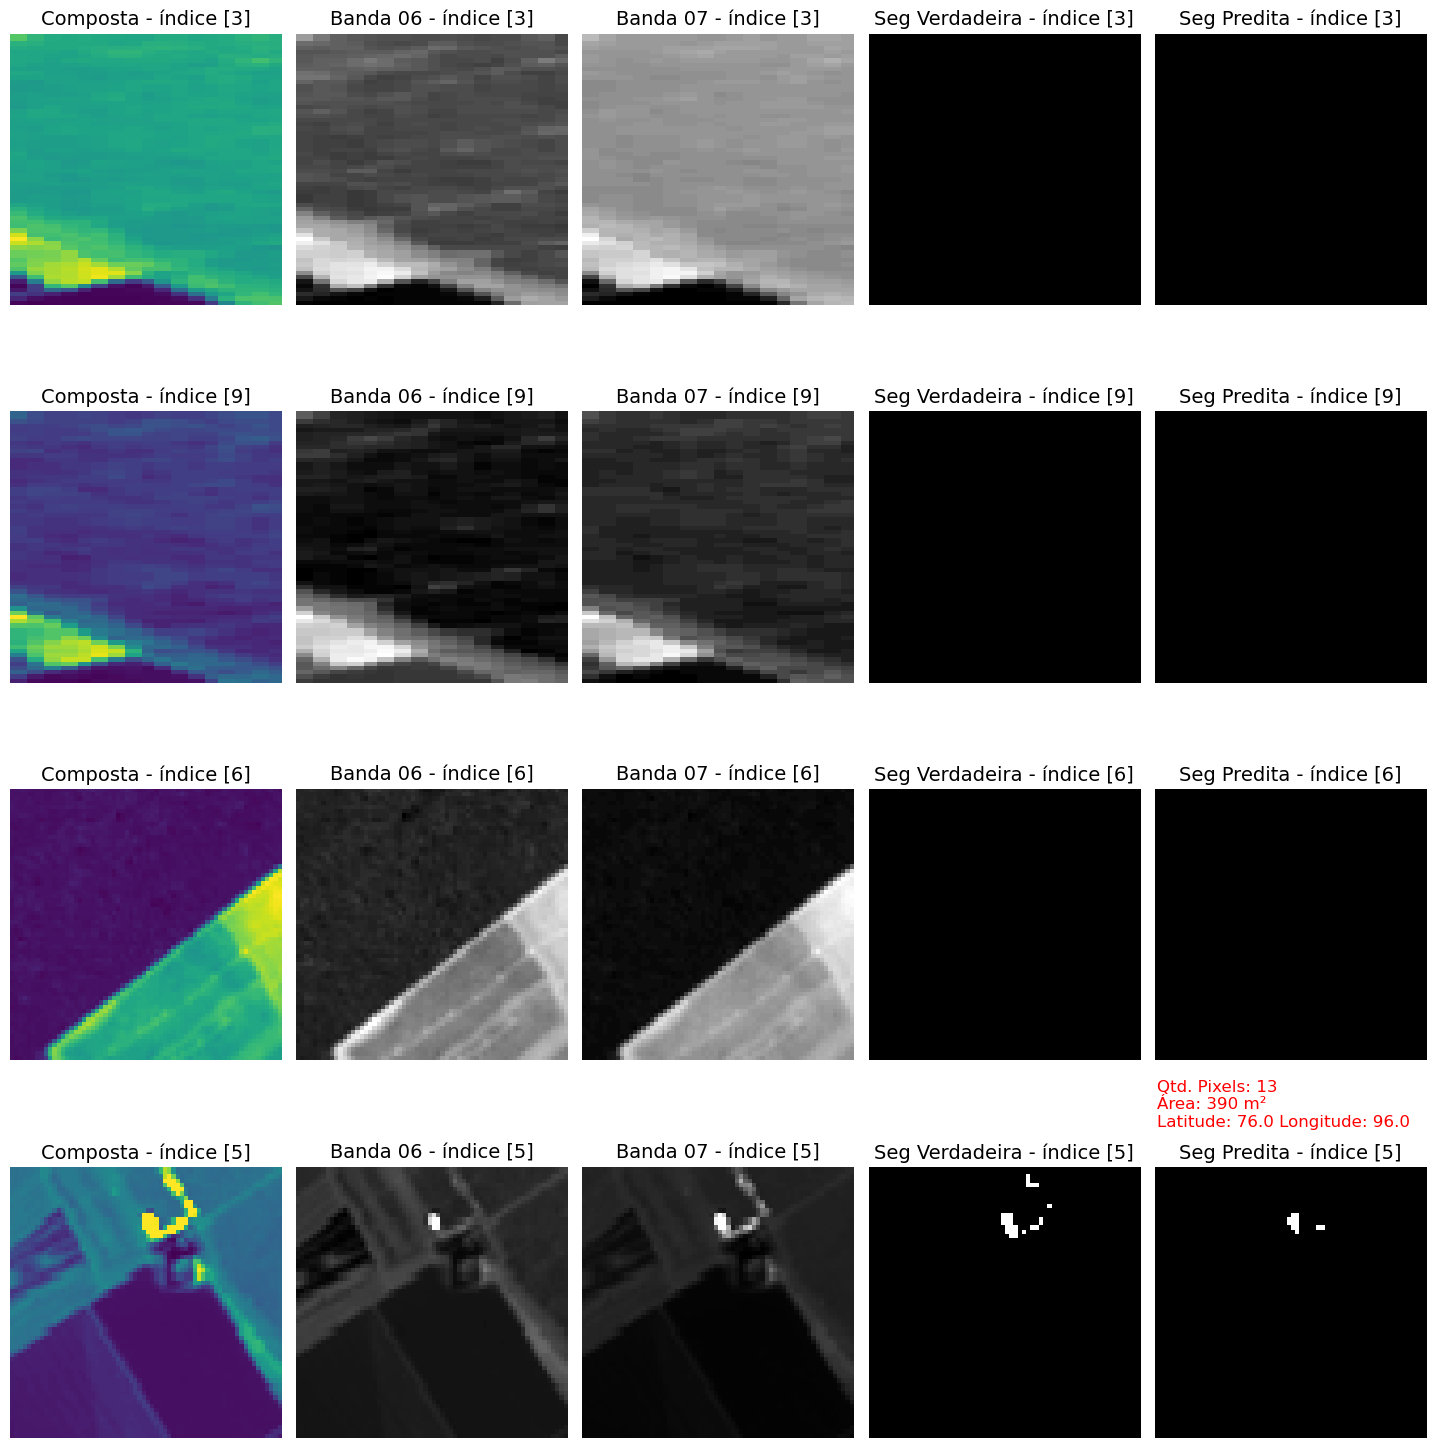

In [51]:
def plot_resultado(quantidade=4):
    # Ler o arquivo final.csv para obter os índices

    indices, latitudes, longitudes = ler_arquivo_indices(saida_rede, os.path.join(saida_rede, 'informacoes_merged.csv'))

    nome_arquivo_qtd_pixel = 'qtd_pixel.csv'
    mapa_qtd_pixel_area = ler_arquivo_qtd_pixel(saida_rede, nome_arquivo_qtd_pixel)

    # random.shuffle(indices)
    # indices_selecionados = indices[:quantidade]
    indices_selecionados = random.sample(indices, quantidade)
    print(indices_selecionados)
    plt.figure(figsize=(15, 15))
    j = 1
    for i, indice in enumerate(indices_selecionados):
        b0 = Z_test.reshape((-1, IMG_HEIGHT, IMG_WIDTH))[indice]
        b1 = X_test[indice, :, :, 0].reshape((IMG_HEIGHT, IMG_WIDTH))
        b2 = X_test[indice, :, :, 1].reshape((IMG_HEIGHT, IMG_WIDTH))
        seg = Y_test.reshape((-1, IMG_HEIGHT, IMG_WIDTH))[indice]
        img_pred = preds_test_thresh[indice].reshape((IMG_HEIGHT, IMG_WIDTH))
       
        imgs = [b0, b1, b2, seg, img_pred]
        names = ['Composta', 'Banda 06', 'Banda 07', 'Seg Verdadeira', 'Seg Predita']

        for img, nome in zip(imgs, names):
            cmap = None if nome == 'Composta' else 'gray'
            plt.subplot(quantidade, 5, j)
            plt.imshow(img, cmap=cmap)
            plt.title(str(nome) + ' - índice [' + str(indice) + ']', fontsize=14)
            plt.axis('off')

            if j % 5 == 0 and indice in mapa_qtd_pixel_area:
                qtd_pixel, area = mapa_qtd_pixel_area[indice]
                plt.text(0,
                         -10,
                         f'Qtd. Pixels: {qtd_pixel}\nÁrea: {area} m²\nLatitude: {latitudes[i]} Longitude: {longitudes[i]}',
                         color='red',
                         fontsize=12,
                         ha='left')

            j += 1
    plt.tight_layout()
    plt.show()


plot_resultado()
